# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [5]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [6]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

In [ ]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [7]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [8]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [9]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [10]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [11]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### TODO: Set self.activation_function to your implemented sigmoid function ####
        #
        # Note: in Python, you can define a function with a lambda expression,
        # as shown below.
        
            
        
        # Replace 0 with your sigmoid calculation.
        
        ### If the lambda code above is not something you're familiar with,
        # You can uncomment out the following three lines and put your 
        # implementation there instead.
        #
        def sigmoid(x):
            return 1/(1+ np.exp(-x))  # Replace 0 with your sigmoid calculation here
        self.activation_function = sigmoid
                    
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer - Replace these values with your calculations.
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs)
        final_outputs = final_inputs # signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error - Replace this value with your calculations.
        output_errors = (targets - final_outputs)  # Output layer error is the difference between desired target and actual output.
      
        # TODO: Backpropagated error - Replace these values with your calculations.
        hidden_errors = np.dot(self.weights_hidden_to_output.T , output_errors) # errors propagated to the hidden layer
        hidden_grad =  hidden_outputs * (1-hidden_outputs) # hidden layer gradients
        
        # TODO: Update the weights - Replace these values with your calculations.
        self.weights_hidden_to_output +=   self.lr* np.dot(output_errors, hidden_outputs.T)# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr* np.dot(hidden_errors*hidden_grad, inputs.T)
        # update input-to-hidden weights with gradient descent step
 
        
    def run(self, inputs_list):
           # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer - replace these values with the appropriate calculations.
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)# signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with the appropriate calculations.
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = final_inputs # signals from final output layer 
        print(inputs)
        return final_outputs

In [12]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [15]:
import sys

### Set the hyperparameters here ###
epochs = 1500
learning_rate = 0.3
hidden_nodes = 16
output_nodes = 3

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 0.0% ... T

Progress: 0.46% ... Training loss: 0.452 ... Validation loss: 0.721[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 1.13% ... Training loss: 0.327 ... Validation loss: 0.475[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 1.8% ... Training loss: 0.274 ... Validation loss: 0.458[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.      

Progress: 2.33% ... Training loss: 0.330 ... Validation loss: 0.515[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 2.86% ... Training loss: 0.224 ... Validation loss: 0.352[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 3.4% ... Training loss: 0.233 ... Validation loss: 0.396[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.      

Progress: 4.06% ... Training loss: 0.169 ... Validation loss: 0.330[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 4.6% ... Training loss: 0.158 ... Validation loss: 0.261[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.      

Progress: 5.33% ... Training loss: 0.166 ... Validation loss: 0.259[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 6.06% ... Training loss: 0.131 ... Validation loss: 0.242[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.     

Progress: 6.73% ... Training loss: 0.126 ... Validation loss: 0.238[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 7.46% ... Training loss: 0.145 ... Validation loss: 0.251[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

Progress: 8.2% ... Training loss: 0.116 ... Validation loss: 0.220[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.      

Progress: 8.73% ... Training loss: 0.113 ... Validation loss: 0.219[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 9.26% ... Training loss: 0.105 ... Validation loss: 0.180[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 9.86% ... Training loss: 0.126 ... Validation loss: 0.200[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 10.4% ... Training loss: 0.120 ... Validation loss: 0.214[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 11.0% ... Training loss: 0.087 ... Validation loss: 0.170[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 11.5% ... Training loss: 0.110 ... Validation loss: 0.190[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 12.0% ... Training loss: 0.123 ... Validation loss: 0.236[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 12.6% ... Training loss: 0.094 ... Validation loss: 0.207[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 13.1% ... Training loss: 0.098 ... Validation loss: 0.237[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 13.6% ... Training loss: 0.102 ... Validation loss: 0.183[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 14.4% ... Training loss: 0.084 ... Validation loss: 0.161[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.     

Progress: 15.1% ... Training loss: 0.100 ... Validation loss: 0.181[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 15.8% ... Training loss: 0.125 ... Validation loss: 0.214[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 16.5% ... Training loss: 0.101 ... Validation loss: 0.162[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

Progress: 17.0% ... Training loss: 0.173 ... Validation loss: 0.275[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 17.7% ... Training loss: 0.104 ... Validation loss: 0.208[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 18.2% ... Training loss: 0.081 ... Validation loss: 0.173[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 18.8% ... Training loss: 0.096 ... Validation loss: 0.167[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 19.3% ... Training loss: 0.086 ... Validation loss: 0.167[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 20.0% ... Training loss: 0.082 ... Validation loss: 0.178[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 20.6% ... Training loss: 0.107 ... Validation loss: 0.273[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 21.2% ... Training loss: 0.097 ... Validation loss: 0.249[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 21.8% ... Training loss: 0.078 ... Validation loss: 0.177[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 22.4% ... Training loss: 0.098 ... Validation loss: 0.340[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 23.0% ... Training loss: 0.116 ... Validation loss: 0.203[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 23.7% ... Training loss: 0.127 ... Validation loss: 0.188[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 24.2% ... Training loss: 0.096 ... Validation loss: 0.203[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 24.8% ... Training loss: 0.095 ... Validation loss: 0.196[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 25.3% ... Training loss: 0.101 ... Validation loss: 0.183[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 26.0% ... Training loss: 0.089 ... Validation loss: 0.180[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 26.5% ... Training loss: 0.085 ... Validation loss: 0.172[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 27.0% ... Training loss: 0.103 ... Validation loss: 0.172[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 27.8% ... Training loss: 0.074 ... Validation loss: 0.185[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 28.4% ... Training loss: 0.103 ... Validation loss: 0.218[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 28.9% ... Training loss: 0.075 ... Validation loss: 0.189[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 29.4% ... Training loss: 0.109 ... Validation loss: 0.263[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 30.1% ... Training loss: 0.097 ... Validation loss: 0.220[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 30.8% ... Training loss: 0.083 ... Validation loss: 0.182[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 31.6% ... Training loss: 0.071 ... Validation loss: 0.159[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 32.2% ... Training loss: 0.090 ... Validation loss: 0.198[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.     

Progress: 33.0% ... Training loss: 0.073 ... Validation loss: 0.165[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 33.5% ... Training loss: 0.091 ... Validation loss: 0.175[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 34.2% ... Training loss: 0.090 ... Validation loss: 0.198[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

Progress: 34.8% ... Training loss: 0.082 ... Validation loss: 0.179[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 35.3% ... Training loss: 0.083 ... Validation loss: 0.194[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 36.0% ... Training loss: 0.076 ... Validation loss: 0.183[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 36.5% ... Training loss: 0.072 ... Validation loss: 0.186[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 37.2% ... Training loss: 0.097 ... Validation loss: 0.182[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 37.8% ... Training loss: 0.088 ... Validation loss: 0.199[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 38.5% ... Training loss: 0.074 ... Validation loss: 0.178[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

Progress: 39.0% ... Training loss: 0.078 ... Validation loss: 0.171[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 39.6% ... Training loss: 0.100 ... Validation loss: 0.185[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 40.3% ... Training loss: 0.067 ... Validation loss: 0.180[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 40.8% ... Training loss: 0.097 ... Validation loss: 0.251[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 41.4% ... Training loss: 0.079 ... Validation loss: 0.214[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 42.1% ... Training loss: 0.076 ... Validation loss: 0.178[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 42.6% ... Training loss: 0.095 ... Validation loss: 0.162[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 43.2% ... Training loss: 0.087 ... Validation loss: 0.188[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 43.7% ... Training loss: 0.113 ... Validation loss: 0.271[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 44.4% ... Training loss: 0.103 ... Validation loss: 0.252[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 44.9% ... Training loss: 0.078 ... Validation loss: 0.200[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 45.4% ... Training loss: 0.084 ... Validation loss: 0.183[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

Progress: 46.0% ... Training loss: 0.087 ... Validation loss: 0.189[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 46.6% ... Training loss: 0.100 ... Validation loss: 0.215[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 47.2% ... Training loss: 0.091 ... Validation loss: 0.183[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 47.8% ... Training loss: 0.072 ... Validation loss: 0.215[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 48.4% ... Training loss: 0.078 ... Validation loss: 0.184[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 48.9% ... Training loss: 0.072 ... Validation loss: 0.199[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 49.6% ... Training loss: 0.074 ... Validation loss: 0.286[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 50.2% ... Training loss: 0.078 ... Validation loss: 0.195[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 50.8% ... Training loss: 0.061 ... Validation loss: 0.174[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 51.4% ... Training loss: 0.076 ... Validation loss: 0.275[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

Progress: 52.1% ... Training loss: 0.077 ... Validation loss: 0.225[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 52.8% ... Training loss: 0.078 ... Validation loss: 0.197[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 53.3% ... Training loss: 0.082 ... Validation loss: 0.227[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 54.0% ... Training loss: 0.109 ... Validation loss: 0.206[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 54.6% ... Training loss: 0.069 ... Validation loss: 0.189[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 55.2% ... Training loss: 0.104 ... Validation loss: 0.219[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 55.8% ... Training loss: 0.094 ... Validation loss: 0.224[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 56.5% ... Training loss: 0.079 ... Validation loss: 0.169[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.     

 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 57.1% ... Training loss: 0.077 ... Validation loss: 0.219[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

Progress: 57.7% ... Training loss: 0.076 ... Validation loss: 0.170[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 58.3% ... Training loss: 0.110 ... Validation loss: 0.241[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 58.9% ... Training loss: 0.066 ... Validation loss: 0.177[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 59.5% ... Training loss: 0.083 ... Validation loss: 0.167[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 60.2% ... Training loss: 0.072 ... Validation loss: 0.186[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 60.8% ... Training loss: 0.109 ... Validation loss: 0.265[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 61.5% ... Training loss: 0.089 ... Validation loss: 0.232[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 62.2% ... Training loss: 0.073 ... Validation loss: 0.203[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 62.8% ... Training loss: 0.076 ... Validation loss: 0.177[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.     

Progress: 63.4% ... Training loss: 0.067 ... Validation loss: 0.178[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 64.1% ... Training loss: 0.086 ... Validation loss: 0.220[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 64.7% ... Training loss: 0.067 ... Validation loss: 0.175[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 65.4% ... Training loss: 0.074 ... Validation loss: 0.214[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 66.0% ... Training loss: 0.074 ... Validation loss: 0.167[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 66.6% ... Training loss: 0.077 ... Validation loss: 0.199[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 67.2% ... Training loss: 0.093 ... Validation loss: 0.165[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 67.7% ... Training loss: 0.076 ... Validation loss: 0.171[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 68.2% ... Training loss: 0.082 ... Validation loss: 0.162[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 68.8% ... Training loss: 0.075 ... Validation loss: 0.213[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 69.3% ... Training loss: 0.073 ... Validation loss: 0.170[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 69.8% ... Training loss: 0.064 ... Validation loss: 0.151[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 70.4% ... Training loss: 0.073 ... Validation loss: 0.154[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 70.9% ... Training loss: 0.079 ... Validation loss: 0.157[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 71.4% ... Training loss: 0.110 ... Validation loss: 0.189[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 72.0% ... Training loss: 0.072 ... Validation loss: 0.158[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.    

Progress: 72.5% ... Training loss: 0.077 ... Validation loss: 0.160[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 73.0% ... Training loss: 0.076 ... Validation loss: 0.155[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 73.6% ... Training loss: 0.068 ... Validation loss: 0.153[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 74.1% ... Training loss: 0.073 ... Validation loss: 0.162[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 74.6% ... Training loss: 0.112 ... Validation loss: 0.252[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 75.2% ... Training loss: 0.072 ... Validation loss: 0.204[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 75.7% ... Training loss: 0.065 ... Validation loss: 0.171[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 76.2% ... Training loss: 0.100 ... Validation loss: 0.183[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 76.8% ... Training loss: 0.073 ... Validation loss: 0.185[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 77.3% ... Training loss: 0.077 ... Validation loss: 0.154[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 77.8% ... Training loss: 0.065 ... Validation loss: 0.166[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 78.4% ... Training loss: 0.079 ... Validation loss: 0.227[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 78.9% ... Training loss: 0.067 ... Validation loss: 0.194[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 79.4% ... Training loss: 0.096 ... Validation loss: 0.172[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 80.0% ... Training loss: 0.075 ... Validation loss: 0.215[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 80.5% ... Training loss: 0.077 ... Validation loss: 0.169[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 81.0% ... Training loss: 0.072 ... Validation loss: 0.157[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 81.6% ... Training loss: 0.070 ... Validation loss: 0.202[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 82.1% ... Training loss: 0.076 ... Validation loss: 0.187[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 82.6% ... Training loss: 0.066 ... Validation loss: 0.178[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 83.2% ... Training loss: 0.078 ... Validation loss: 0.223[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 83.7% ... Training loss: 0.074 ... Validation loss: 0.187[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 84.2% ... Training loss: 0.094 ... Validation loss: 0.165[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 84.8% ... Training loss: 0.070 ... Validation loss: 0.179[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 85.3% ... Training loss: 0.191 ... Validation loss: 0.275[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 85.8% ... Training loss: 0.072 ... Validation loss: 0.197[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 86.4% ... Training loss: 0.101 ... Validation loss: 0.289[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 86.9% ... Training loss: 0.080 ... Validation loss: 0.245[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 87.4% ... Training loss: 0.068 ... Validation loss: 0.183[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 88.0% ... Training loss: 0.076 ... Validation loss: 0.245[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
Progress: 88.7% ... Training loss: 0.070 ... Validation loss: 0.215[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.     

Progress: 89.4% ... Training loss: 0.092 ... Validation loss: 0.245[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 90.0% ... Training loss: 0.065 ... Validation loss: 0.204[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 90.5% ... Training loss: 0.077 ... Validation loss: 0.177[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 91.0% ... Training loss: 0.087 ... Validation loss: 0.167[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 91.6% ... Training loss: 0.199 ... Validation loss: 0.379[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 92.1% ... Training loss: 0.079 ... Validation loss: 0.162[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 92.6% ... Training loss: 0.061 ... Validation loss: 0.187[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 93.2% ... Training loss: 0.085 ... Validation loss: 0.186[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 93.7% ... Training loss: 0.076 ... Validation loss: 0.175[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 94.2% ... Training loss: 0.096 ... Validation loss: 0.182[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 94.8% ... Training loss: 0.071 ... Validation loss: 0.150[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 95.3% ... Training loss: 0.071 ... Validation loss: 0.177[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 95.8% ... Training loss: 0.072 ... Validation loss: 0.169[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 96.4% ... Training loss: 0.063 ... Validation loss: 0.196[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 96.9% ... Training loss: 0.071 ... Validation loss: 0.188[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 97.4% ... Training loss: 0.076 ... Validation loss: 0.199[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 98.0% ... Training loss: 0.082 ... Validation loss: 0.163[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 98.5% ... Training loss: 0.099 ... Validation loss: 0.272[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 99.0% ... Training loss: 0.076 ... Validation loss: 0.191[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

Progress: 99.6% ... Training loss: 0.161 ... Validation loss: 0.322[[ 0.          0.          0.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [-1.33460919 -1.43847501 -1.43847501 ..., -0.19208513 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 1.          1.          1.         ...,  0.          0.          0.        ]]
[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651  0.22337816  0.32724398 ...,  0.11951233 -0.19208513
  -0.19208513]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.     

(-0.025828987408265364, 1)

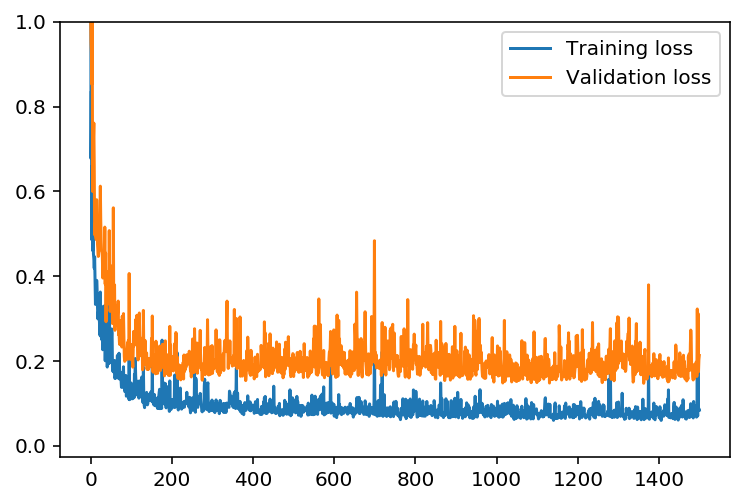

In [16]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=1)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

[[ 1.          1.          1.         ...,  1.          1.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.01564651 -0.19208513 -0.19208513 ..., -1.23074336 -1.23074336
  -1.23074336]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


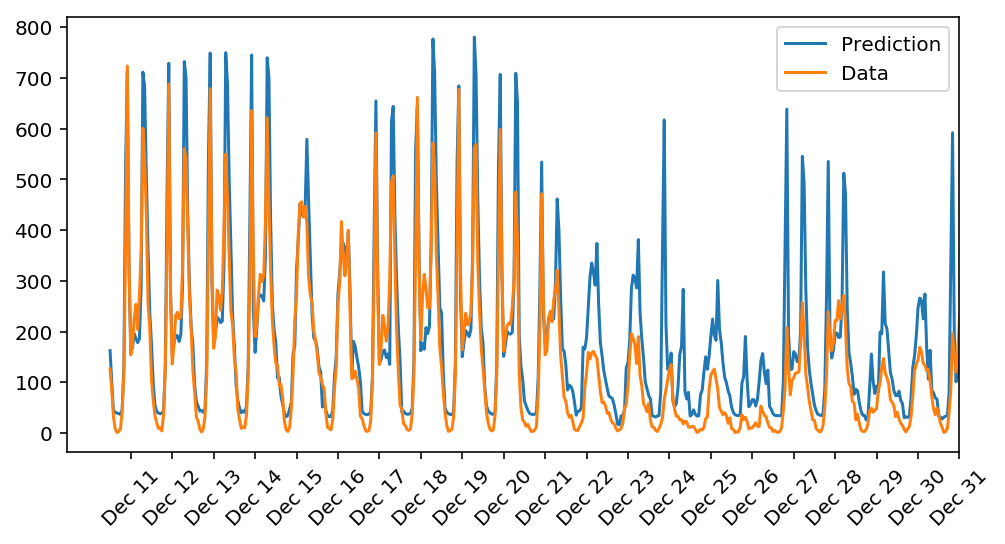

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> R) A maior parte dos erros da previsão acontecem nos últimos dias do ano, isso pode ser motivado pelo período de festas, onde menos pessoas utilizam as bicicletas , assim tendo menos dados para aprender.

#### Your answer below

## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.

In [18]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....

[[ 0.5]
 [-0.2]
 [ 0.1]]



----------------------------------------------------------------------
Ran 5 tests in 0.039s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>